## Streaming-Based Anomaly Detection and Intervention Recommendation in ICU Monitoring via Unsupervised Signal Analysis

# Name: Roshini Jayasankar 
# Date: 05/12/2025
----
## Executive Summary

Patients in Intensive Care Units (ICUs) are highly susceptible to sudden physiological deterioration. Effective monitoring requires continuous, high-resolution tracking of vital signs such as arterial blood pressure (ABP), respiratory rate (RESP), and photoplethysmogram (PLETH). PLETH is a waveform that reflects volumetric changes in blood circulation and is typically measured via pulse oximetry. It provides critical information about a patient’s cardiovascular status and is commonly used to assess oxygen saturation and peripheral perfusion.

Conventional ICU monitoring systems rely heavily on threshold-based alarms and retrospective analysis, both of which are limited in their ability to detect early signs of clinical deterioration. These limitations contribute to high false alarm rates and delayed interventions, which can compromise patient outcomes.

This project proposes a streaming-based framework for unsupervised anomaly detection and clinical decision support tailored for real-time ICU monitoring. Building on prior work in statistical time-series anomaly detection, the system simulates real-time data streams using Kafka, applies unsupervised learning algorithms (Isolation Forest and One-Class SVM), and incorporates a patient similarity recommendation module based on clustering. While Dynamic Time Warping (DTW) was initially considered for similarity matching, it was excluded due to computational limitations. Instead, both **K-Means** and **Agglomerative Clustering** were implemented to identify patient groups based on waveform patterns by phsiological similarity. Model interpretability is addressed through the use of SHAP (SHapley Additive Explanations), which provides transparent insights into feature contributions for detected anomalies.

The data source for this study is the MIMIC-III Waveform Database Matched Subset, which contains high-frequency, multi-channel physiological waveform data aligned with clinical events. Preliminary exploration of a selected sample confirmed the dataset's suitability for both streaming simulation and unsupervised signal analysis.

**Key deliverables of this project include:**
- A real-time Kafka-based data ingestion and processing pipeline 
- Anomaly detection models using Isolation Forest and One-Class SVM  
- A patient similarity engine based on K-Means and Agglomerative Clustering  
- SHAP-based interpretability tools to visualize and explain model outputs  
- Comparative visual and quantitative evaluations of model performance  

By shifting from static analysis to continuous, interpretable monitoring, this framework aims to improve ICU analytics by enabling earlier interventions, reducing false alarms, and supporting patient-specific decision-making.

---

## Problem Statement & Goals

Intensive Care Units (ICUs) manage patients in critical condition, where rapid physiological deterioration is a constant risk. Continuous and accurate monitoring is essential, yet traditional systems often fail to detect subtle or evolving anomalies in real time. In addition, high false alarm rates contribute to alarm fatigue, which may desensitize clinical staff and compromise patient safety.

This project addresses these challenges by proposing a real-time, data-driven anomaly detection and recommendation framework using high-frequency physiological waveform data. The system aims to identify atypical signal patterns and suggest potential interventions by clustering patients with similar physiological profiles.

Project Goals:
- Simulate real-time ICU data streaming using Kafka
- Detect physiological anomalies using unsupervised machine learning models (Isolation Forest and One-Class SVM)
- Generate personalized recommendations through clustering (K-Means and Agglomerative Clustering)
- Improve model transparency through SHAP-based interpretability
- Evaluate model performance using visual diagnostics and quantitative metrics (e.g., anomaly score distributions)




-------

## Data Summary

This project uses the MIMIC-III Waveform Database Matched Subset, a publicly available dataset hosted on PhysioNet. It links high-resolution physiological waveform data with clinical records from over 10,000 unique ICU stays. The dataset is particularly well-suited for time-series and streaming analysis due to its high sampling frequency and wide range of vital signal modalities.

Each waveform record typically contains digitized physiological signals sampled at 125 Hz, including:
- **Electrocardiogram (ECG):** Electrical activity of the heart from multiple leads (e.g., II, V, aVR)  
- **RESP (Respiratory waveform):** Breathing rate and depth  
- **PLETH (Photoplethysmogram):** A non-invasive measure of blood volume changes captured via pulse oximetry  
- **ABP (Arterial Blood Pressure):** Measurement of blood pressure dynamics in mmHg  

The signals are stored as multi-segment files per patient, with each segment representing a continuous recording window. For this project, 10 segments were selected from a representative ICU patient record (ID: `p044083-2112-05-04-19-50`). These segments vary in length and signal completeness, allowing for realistic exploration of common data quality challenges in ICU settings.

A preliminary review of the selected waveform segments revealed substantial variability in data quality and completeness. Early segments (e.g., `0001–0004`) exhibited high levels of missing data and flatlined signals across multiple channels, likely due to a sensor dropout or incomplete acquisition. In contrast, later segments (e.g., `0005–0010`) were consistently sampled and contained multichannel signals suitable for modeling.

This segment-level variability directly influenced the data preprocessing strategy and guided the selective modeling approach adopted in the remainder of the project.




## Exploratory Data Analysis


In [ ]:
!pip install scipy==1.10.1 --force-reinstall

In [19]:
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/9b/34/0c964b0c96d7ac77b8fb8e71968a846f1d5dbc9e4973333fde7aef6740fc/shap-0.47.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.4/546.4 kB 19.0 MB/s eta 0:00:00


In [2]:
# Load required libraries

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import wfdb
import os
import shap
import json
import time
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from kafka import KafkaProducer
from kafka import KafkaConsumer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

**Load and Preprocess ICU Waveform Segments**

The 10 waveform segments from a single ICU patient were loaded and selected to include a mix of signal quality and duration. Each segment contains multichannel physiological data such as RESP, PLETH, ABP, and ECG leads. The files were analyzed using the WFDB library, and all signals were joined into a single DataFrame for unified analysis. 

After loading, channels with missing values('MCL') were removed and fully empty rows are discarded. Finally, forward-filling was applied to remaining missing values to maintaing continuity without introducing artificial variation. 

In [3]:
# Define the local path to the directory containing waveform segment files 
base_path = "/Users/roshinijay/Documents/mimic3_sample_records"

# List of segment identifiers corresponding to one ICU patient session
segment_files = [
    '3314767_0001', '3314767_0002', '3314767_0003',
    '3314767_0004', '3314767_0005', '3314767_0006',
    '3314767_0007', '3314767_0008', '3314767_0009',
    '3314767_0010'
]

# Initialize list to store DataFrames for each segment
all_segments = []

# Loop through all segment paths and read each record
for seg in segment_files:
    seg_path = os.path.join(base_path, seg)
    try:
        # Load the waveform record using WFDB and extract signal matrix
        record = wfdb.rdrecord(seg_path)
        signals = pd.DataFrame(record.p_signal, columns=record.sig_name)
        signals['segment'] = seg # Track segment ID for reference
        all_segments.append(signals)
    except Exception as e:
        print(f"Error loading {seg}: {e}") 

# Combine all segments into one DataFrame for processing
waveform_df = pd.concat(all_segments, ignore_index=True)

# Drop MCL if present due to poor signal quality
if 'MCL' in waveform_df.columns:
    waveform_df.drop(columns=['MCL'], inplace=True)

# Drop rows where all signal values are missing
waveform_df = waveform_df.dropna(subset=['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR'], how='all')

# Forward fill remaining missing values to perserve continuity
waveform_df = waveform_df.ffill()

**Exploratory Data Analysis: Signal Variance, Missingness,and Correlation**

Before applying modeling, it’s critical to assess the quality and behavior of the raw waveform data. The below code performs a series of exploratory diagnostics:

- Variance analysis per segment helps to detect flatline signals (very low variance).
- Missing value percentages identify problematic channels or segments.
- Signal distribution histograms visualize typical ranges and skewness.
- Correlation matrices quantify the relationship between signals, such as ABP and PLETH.
- Pearson correlation and ANOVA tests provide statistical grounding for signal relationships across segments.

These insights set the path for modeling.



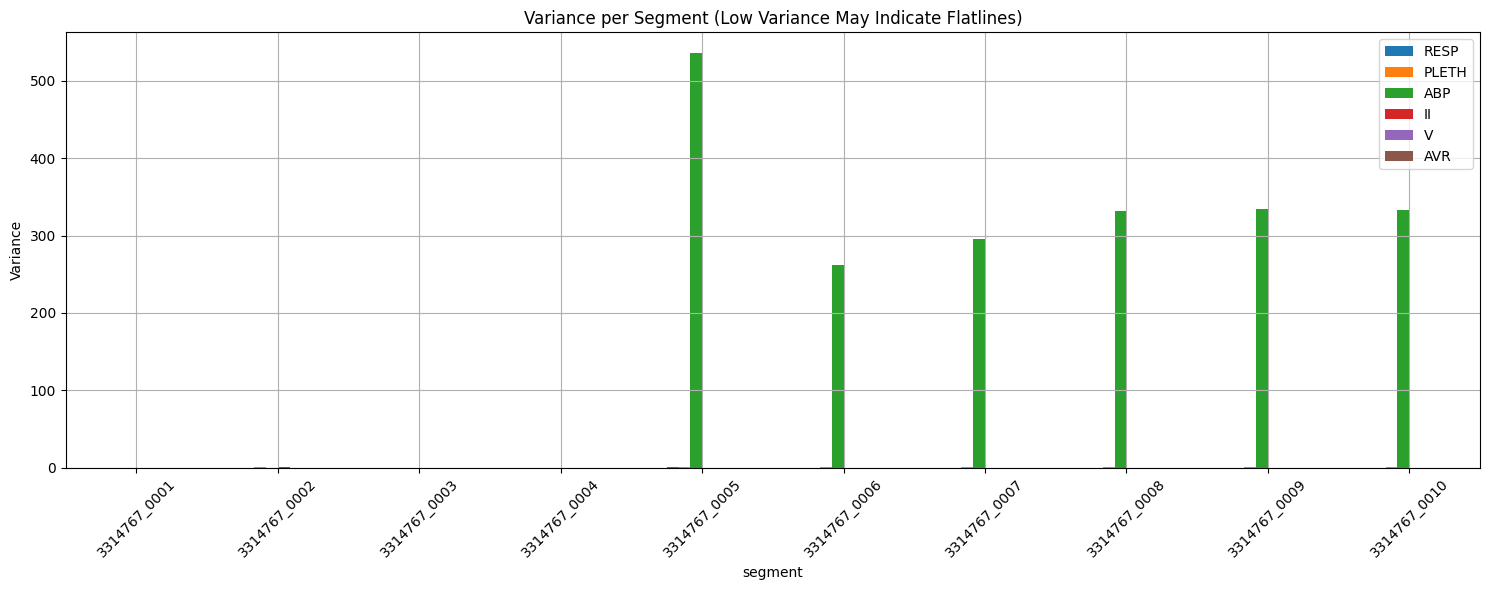

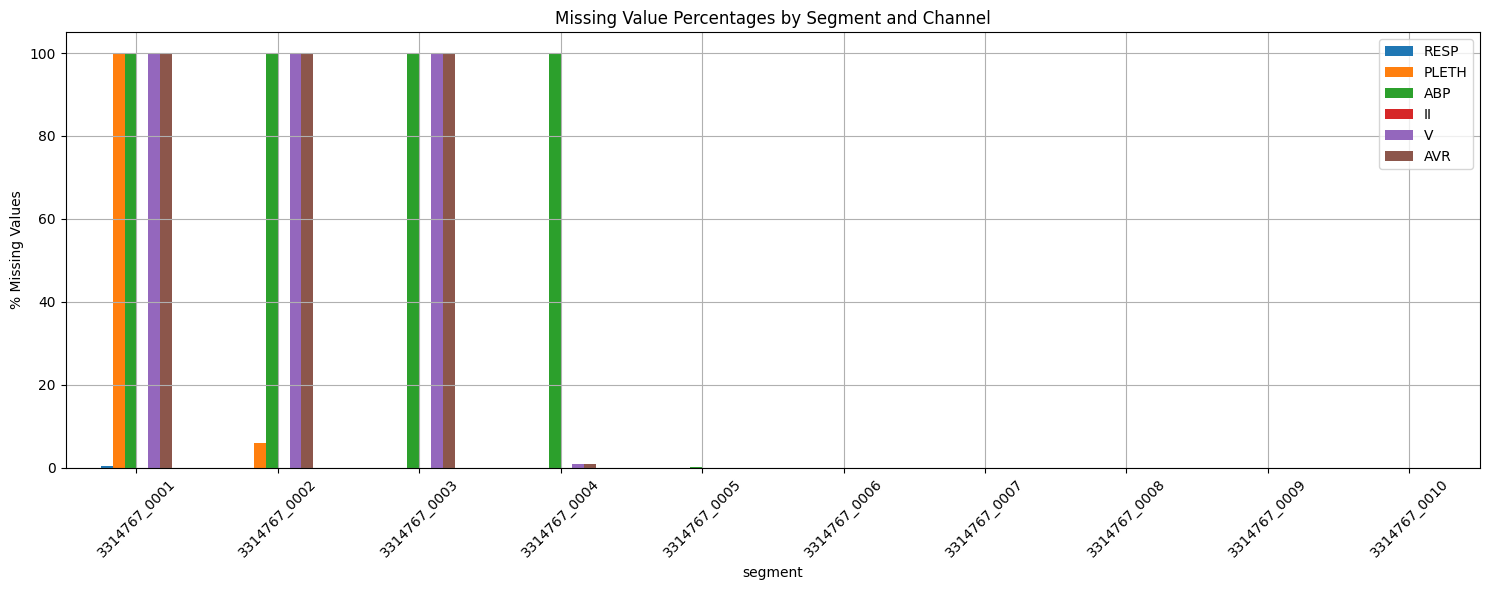

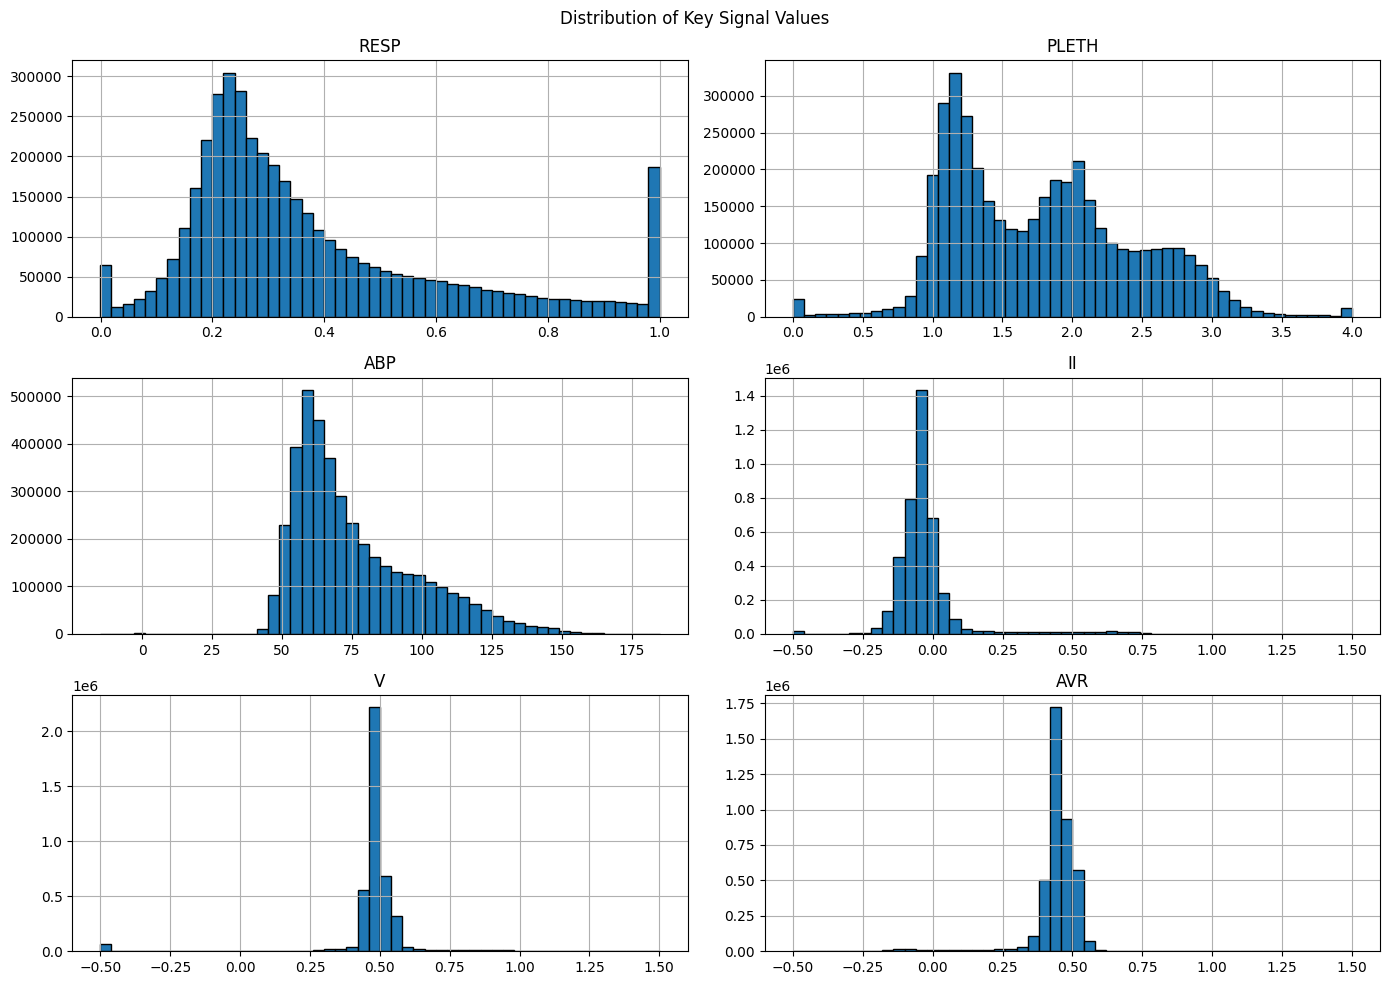

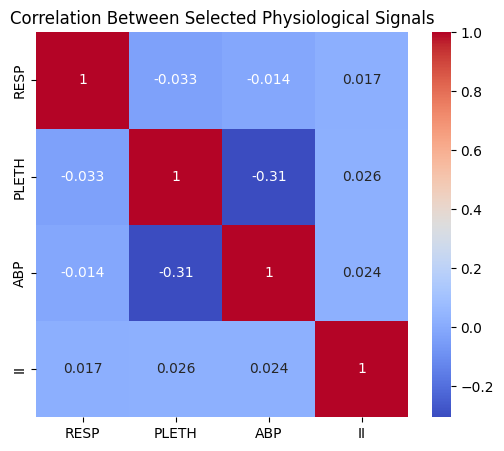

Pearson r = 0.043, p-value = 0.00000
ANOVA F-statistic: 26642.823, p-value: 0.00000


In [4]:
# Minimum number of non-NA values requried to compute variance
min_required_values = 2

# Safe variance function to avoid errors with segments that are mostly missing
def safe_variance(x):
    if x.dropna().shape[0] >= min_required_values:
        return np.nanvar(x) # Compute variance ignoring NaNs
    else:
        return np.nan  # Flag as NaN if insufficient data

# Apply variance commputation to each segment
segment_variances = waveform_df.groupby("segment").agg(safe_variance)

# Plot variance across segments
segment_variances[['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']].plot(kind='bar', figsize=(15, 6))
plt.title("Variance per Segment (Low Variance May Indicate Flatlines)")
plt.ylabel("Variance")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcuate percentage of missing values for each signal by segment
segment_missing_summary = waveform_df.groupby("segment")[
    ['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']
].apply(lambda df: df.isnull().mean() * 100).reset_index()

# Plot missing data heatmap per segment
segment_missing_summary.set_index('segment').plot(kind='bar', figsize=(15, 6))
plt.ylabel("% Missing Values")
plt.title("Missing Value Percentages by Segment and Channel")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Signal Distribution Histograms 
waveform_df[['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']].hist(
    figsize=(14, 10), bins=50, edgecolor='black'
)
plt.suptitle("Distribution of Key Signal Values")
plt.tight_layout()
plt.show()

# Compute Pearson correlation between selected signals
correlation_matrix = waveform_df[['RESP', 'PLETH', 'ABP', 'II']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Selected Physiological Signals")
plt.show()

# Drop NA to ensure valid input
abp_clean = waveform_df['ABP'].dropna()
pleth_clean = waveform_df['PLETH'].dropna()

# Match lengths to ensure valid comparison
min_len = min(len(abp_clean), len(pleth_clean))
abp_aligned = abp_clean.iloc[:min_len]
pleth_aligned = pleth_clean.iloc[:min_len]

# Compute Pearson correlation with p-value
r_val, p_val = pearsonr(abp_aligned, pleth_aligned)
print(f"Pearson r = {r_val:.3f}, p-value = {p_val:.5f}")

# Compare ABP values using ANOVA 
abp_5 = waveform_df[waveform_df['segment'] == '3314767_0005']['ABP'].dropna()
abp_6 = waveform_df[waveform_df['segment'] == '3314767_0006']['ABP'].dropna()
abp_7 = waveform_df[waveform_df['segment'] == '3314767_0007']['ABP'].dropna()

# One-way ANOVA to assess significant differences in ABP means
f_stat, p_val = f_oneway(abp_5, abp_6, abp_7)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_val:.5f}")


**Interpretation of EDA analysis**

The exploratory analysis of ICU waveform segments revealed differences in signal quality and physiological variance across the ten selected segments. Segment-wise variance analysis indicated that the first four segments (0001–0004) had low variability across multiple channels, particularly ABP, PLETH, and AVR, suggesting periods of signal flatlining or sensor inactivity.

In contrast, segments 0005–0010 exhibited higher variance, especially in the ABP channel, indicating more active physiological signals. This distinction was further supported by the missing value analysis, which showed high dropout rates in the early segments and near-complete signal availability in later ones.

The distribution plots provided additional insight into waveform characteristics. The RESP signal displayed a right-skewed distribution, consistent with expected respiratory behavior. PLETH was multimodal, possibly reflecting respiratory modulation or motion artifacts. ABP followed a long-tailed distribution, capturing a range of pressure dynamics from baseline to hypertensive events. As anticipated, ECG leads II, V, and AVR were centered near zero with low variance, reflecting stable cardiac electrical activity.

Pearson correlation analysis revealed a statistically significant but very weak positive correlation between ABP and PLETH (r = 0.043, p < 0.00001), suggesting a slight shared trend likely attributable to circulatory dynamics, though the relationship is not clinically strong. Similarly, minimal correlation was observed between RESP and cardiac signals, underscoring the relative independence of respiratory and cardiovascular rhythms in this dataset.

Finally, a one-way ANOVA comparing ABP values across segments 0005–0007 confirmed statistically significant differences in mean blood pressure (F = 26,642.82, p < 0.00001), reinforcing the presence of real physiological variation.

These findings together justified the exclusion of earlier, low-quality segments from further modeling and helped shape the preprocessing and feature selection strategy for downstream analysis.




## Data Preparation

Before modeling, several preprocessing steps were performed to ensure that the physiological signals were clean, consistent, and suitable for analysis. These steps were guided by insights from the exploratory data analysis, with the goal of reducing noise, handling missing data, and standardizing input formats.

**Segment Selection Based on Quality Criteria**

The initial dataset included ten waveform segments extracted from a single ICU patient record. However, analysis of segment-wise missingness and variance revealed substantial differences in data quality. Segments `0001` to `0004` exhibited high percentages of missing values—approaching 100% in some channels—and extremely low variance, suggesting flatlined signals or inactive sensors. In contrast, segments `0005` to `0010` showed minimal missing data and consistent physiological variability, making them appropriate for modeling. Therefore, only the higher-quality segments (`0005–0010`) were retained for further analysis.

**Handling Missing Values and Signal Gaps**

After filtering out low-quality segments, missing values were addressed. Rows with missing values across *all* monitored channels (RESP, PLETH, ABP, ECG leads) were removed, as they offered no usable signal information. For rows where only some values were missing, a forward-fill (`ffill`) imputation strategy was applied to maintain temporal coherence. This method is clinically consistent and avoids introducing artificial discontinuities into the time series.

**Normalization**

Normalization was selectively applied based on model requirements. Since Isolation Forest relies on tree-based splits, it is inherently robust to differences in feature scale, and no normalization was applied in that case. In contrast, One-Class SVM is a kernel-based method that is sensitive to feature magnitude, making normalization more critical. Although initial SVM experiments were run on unnormalized data for consistency, this limitation is acknowledged and flagged as an area for future tuning.

For clustering tasks such as K-Means and Agglomerative Clustering—both of which rely on Euclidean distance—z-score standardization was applied to ensure comparability across features that have different units (e.g., mmHg for ABP vs. unitless amplitude for RESP or PLETH). This targeted scaling approach ensured that each modeling technique operated under assumptions appropriate to its underlying algorithm.



**Data Prepartion for Modeling**

The code below selects high-quality segments identified during exploratory analysis and prepares the data for modeling.

Only segments 0005 through 0010 are retained, as earlier segments were found to contain flatlines or excessive missing values. Remaining missing data is imputed using a two-pass forward- and backward-fill strategy. Finally, physiological features are normalized using z-score standardization to ensure compatibility with distance-based and kernel-based algorithms.


In [5]:
# Filter for high-quality segments identified in EDA 
selected_segments = [
    '3314767_0005', '3314767_0006', '3314767_0007',
    '3314767_0008', '3314767_0009', '3314767_0010'
]
waveform_df_filtered = waveform_df[waveform_df['segment'].isin(selected_segments)].copy()

# Drop rows where all signals are missing 
waveform_df_filtered = waveform_df_filtered.dropna(
    subset=['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR'], how='all'
)

# Impute missing values using forward-fill, then backward-fill for leading NaNs
waveform_df_filtered = waveform_df_filtered.ffill().bfill()


# Normalize features using z-score standardization 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(
    waveform_df_filtered[['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']]
)

# Create normalized DataFrame with segment labels preserved 
waveform_scaled_df = pd.DataFrame(
    scaled_features, columns=['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']
)
waveform_scaled_df['segment'] = waveform_df_filtered['segment'].values

# Reset index to maintain consistency
waveform_scaled_df.reset_index(drop=True, inplace=True)

# Display the first few rows of processed and normalized dataset
waveform_scaled_df.head()




,RESP,PLETH,ABP,II,V,AVR,segment
0,0.927199,0.494728,-0.012532,-3.651299,1.331526,4.309014,3314767_0005
1,0.951939,0.545424,-0.012532,-3.651299,1.264398,4.360067,3314767_0005
2,0.969464,0.590156,-0.012532,-3.651299,1.230835,4.411119,3314767_0005
3,0.988019,0.624450,-0.012532,-3.651299,1.193914,4.309014,3314767_0005
4,1.000390,0.649798,-0.012532,-3.651299,1.193914,4.150752,3314767_0005


The preview of the scaled dataset confirms that z-score normalization has been successfully applied to the selected segments. 

All signals are now on a standardized scale, with values centered approximately around zero, which ensures comparability across features in distance and density-based modeling. 

The ABP channel in this subset (segment 3314767_0005) carries a constant normalized value of –0.0125 across multiple time points, suggesting minimal or no variation in the original signal. This pattern may reflect a physiologically stable state or, more likely, a brief flatline or sensor inactivity,consistent with earlier exploratory findings. Similarly, the ECG II lead shows no variation across samples, indicating a potential flat segment or low signal quality during this interval. 


## Modeling

This section outlines the implementation of unsupervised anomaly detection models applied to the preprocessed ICU waveform data. In alignment with the streaming and real-time monitoring goals, two unsupervised learning techniques were selected: Isolation Forest and One-Class SVM. These models were chosen for their ability to detect unusual patterns in high-dimensional physiological signals without requiring labeled training data, an important constraint in clinical applications where anomalies are difficulty to define, label and validate. Additionally, preliminary work was conducted to support the integration of patient similarity-based recommendation system, which is discussed following the modeling stages. 

**Streaming Simulation(Kafka-based)**

To emulate real-time ICU data transmission, a Kafka-based simulation was developed. This simulation reproduces the behavior of bedside monitors by publishing physiological signals in real time. Each row in the preprocessed dataset represents a single time step, comprising of synchronized values across multiple channels (e.g., RESP, ABP, ECG). These rows are serialized into JSON format and sequentially published to a Kafka topic (icu_waveform_stream) with a short delay to mimic real-time pacing behavior.


The Kafka streaming logic consists of the following components:
- Iterative, row-wise traversal through the scaled dataset
- Converts each row into JSON object
- Inserts a short delay between messages to simulate real-time pacing
- Message publishing via KafkaProducer to a designated topic

While the producer itself does not produce a visible output, it successfully streams structured physiological data to a broker, enabling downstream modules to subscribe and consume the data in real time. This architecture provides a foundation for developing real-time analytics such as live anomaly detection, clinical dashboards, or patient similarity matching.

The code implementation, included in the notebook, demonstrates how Kafka can be used to build a lightweight but extensible simulation of streaming ICU telemetry.



**Kafka Streaming Simulation Code**

The following code block initializes a Kafka producer and simulates real-time streaming of ICU waveform data. Each row of the standardized dataset is sent as a JSON-formatted message to a Kafka topic (icu_waveform_stream) with a short delay to mimic clinical pacing. This simulates continuous data flow, enabling real-time analytics such as anomaly detection or similarity-based recommendations downstream.

In [6]:
# Initialize Kafka producer with local broker and JSON seriatlization
producer = KafkaProducer(
    bootstrap_servers='localhost:9092',
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

# Define the Kafka topic for streaming physiological data
stream_topic = 'icu_waveform_stream'

# Stream 100 rows of physiological data to Kafka to simulate real-time data transmission
for idx, row in waveform_scaled_df.iloc[:100].iterrows():
    data_point = {
        'RESP': row['RESP'],
        'PLETH': row['PLETH'],
        'ABP': row['ABP'],
        'II': row['II'],
        'V': row['V'],
        'AVR': row['AVR'],
        'segment': row['segment']
    }
    # Send the structured data to Kafka topic
    producer.send(stream_topic, value=data_point)
    # Delay to simulate real-time sampling
    time.sleep(0.1)
    print(f"Sent data point {idx} to Kafka topic '{stream_topic}'")

# Ensure all messages are sent and resources are released
producer.flush()
producer.close()

Sent data point 0 to Kafka topic 'icu_waveform_stream'
Sent data point 1 to Kafka topic 'icu_waveform_stream'
Sent data point 2 to Kafka topic 'icu_waveform_stream'
Sent data point 3 to Kafka topic 'icu_waveform_stream'
Sent data point 4 to Kafka topic 'icu_waveform_stream'
Sent data point 5 to Kafka topic 'icu_waveform_stream'
Sent data point 6 to Kafka topic 'icu_waveform_stream'
Sent data point 7 to Kafka topic 'icu_waveform_stream'
Sent data point 8 to Kafka topic 'icu_waveform_stream'
Sent data point 9 to Kafka topic 'icu_waveform_stream'
Sent data point 10 to Kafka topic 'icu_waveform_stream'
Sent data point 11 to Kafka topic 'icu_waveform_stream'
Sent data point 12 to Kafka topic 'icu_waveform_stream'
Sent data point 13 to Kafka topic 'icu_waveform_stream'
Sent data point 14 to Kafka topic 'icu_waveform_stream'
Sent data point 15 to Kafka topic 'icu_waveform_stream'
Sent data point 16 to Kafka topic 'icu_waveform_stream'
Sent data point 17 to Kafka topic 'icu_waveform_stream'
Se

**Kafka Consumer for ICU stream Verification**

The code below initializes a Kafka consumer to verify the streaming process. It listens to the same topic (icu_waveform_stream) and reads the first 10 messages published by the producer. This confirms that the real-time data flow is functioning correctly and that the message structure is preserved during transmission.

In [49]:
# Initialize and Limit Kafka consumer to 10 messages
consumer = KafkaConsumer(
    'icu_waveform_stream',
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))
)

# Read and display first 10 messages
print("Starting limited consumer...")
for i, message in enumerate(consumer):
    print(f"Received message {i}: {message.value}")
    if i >= 9:
        break


Starting limited consumer...
Received message 0: {'RESP': 0.5990715856340093, 'PLETH': 2.0899315738025415, 'ABP': nan, 'II': -0.5004887585532747, 'V': 0.6749755620723362, 'AVR': 0.855327468230694}
Received message 1: {'RESP': 0.6049352553139506, 'PLETH': 2.12316715542522, 'ABP': nan, 'II': -0.5004887585532747, 'V': 0.6652003910068426, 'AVR': 0.8602150537634409}
Received message 2: {'RESP': 0.6090886880039091, 'PLETH': 2.1524926686217007, 'ABP': nan, 'II': -0.5004887585532747, 'V': 0.6603128054740958, 'AVR': 0.8651026392961877}
Received message 3: {'RESP': 0.6134864402638651, 'PLETH': 2.174975562072336, 'ABP': nan, 'II': -0.5004887585532747, 'V': 0.6549364613880743, 'AVR': 0.855327468230694}
Received message 4: {'RESP': 0.6164182751038358, 'PLETH': 2.1915933528836753, 'ABP': nan, 'II': -0.5004887585532747, 'V': 0.6549364613880743, 'AVR': 0.8401759530791789}
Received message 5: {'RESP': 0.6195944295138041, 'PLETH': 2.2052785923753664, 'ABP': nan, 'II': -0.5004887585532747, 'V': 0.6549364

**Kafka-Based Streaming Simulation and Output Verification**

A Kafka-based streaming successfully implemented a real-time transmission of ICU waveform data. Using the KafkaProducer module, preprocessed and standardized physiological signals were serialized into JSON format and sequentially transmitted to a Kafka topic (icu_waveform_stream) with a short delay between messages. This delay mimics the sampling rate of bedside monitors and preserves the temporal structure of the signals. Each message encapsulates synchronized values for a single time step across multiple physiological channels, including RESP, PLETH, ABP, and ECG leads (II, V, AVR).

On the receiving end, a KafkaConsumer subscribed to the same topic and successfully retrieved incoming messages in real time. The decoded output displayed a continuous stream of structured physiological snapshots, confirming the producer-consumer pipeline and validating end-to-end data flow. This simulation verifies Kafka’s capability to replicate the temporal characteristics of ICU data streams and establishes a functional foundation for integrating downstream analytics such as anomaly detection or patient similarity analysis.

The ABP signal was consistently missing (NaN) in the sample messages received. This likely reflects either sensor dropout or a flatline condition in the selected segment, an observation consistent with prior exploratory analysis. Importantly, this behavior demonstrates that the streaming pipeline preserves data irregularities present in the source. By retaining missing values and time-aligned signal structure, this Kafka-based simulation offers a realistic and extensible framework for event-driven physiological modeling in healthcare applications.



## Unsupervised Anomaly Detection

This section presents the implementation and evaluation of two unsupervised models used to detect clinically significant deviations in ICU waveform data: Isolation Forest and One-Class SVM. These models were selected based on their compatibility with streaming data, suitability for high-dimensional time series, and ability to operate without data labels. The models were trained on scaled waveform features extracted from segments 0005 to 0010, which were previously identified as high-quality based on exploratory data analysis.


**Isolation Forest**

To identify abnormal physiological patterns, an Isolation Forest was implemented as the primary anomaly detection model. This algorithm works by randomly selecting features and values to split the data, gradually isolating each data point. Its tree-based structure makes it particularly well-suited for high-dimensional, noisy, and unlabeled datasets such as multichannel ICU signals.

Isolation Forest offers several advantages in this clinical context:
- It does not assume a specific data distribution.
- It is inherently robust to outliers and noise.
- It is computationally efficient and scalable for streaming use cases.


The model was applied to the z-score-normalized dataset using six key features: RESP, PLETH, ABP, and three ECG leads (II, V, AVR). The key hyperparameter,contamination, which defines the expected proportion of anomalies,was set to 0.01, reflecting a  assumption that anomalies are rare relative to normal physiological states.

The following section presents the model implementation applied to the preprocessed waveform data.


   anomaly_score_iforest  anomaly_iforest
0               0.132479                0
1               0.127035                0
2               0.125876                0
3               0.129413                0
4               0.124135                0


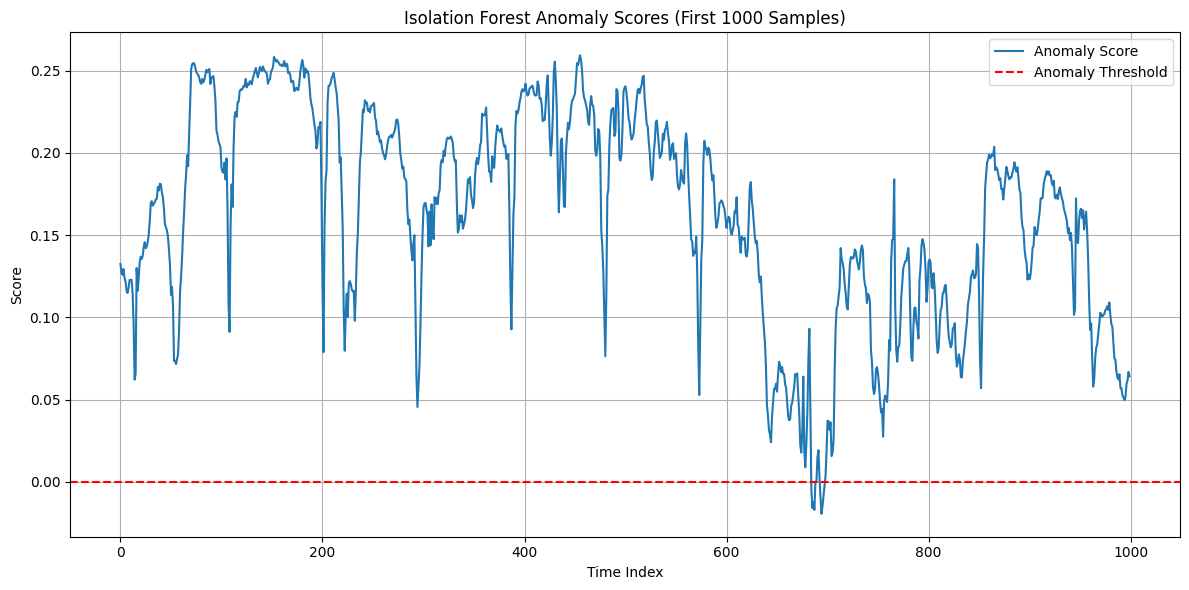

In [53]:
# Subset and prepare the feature data
subset_df = waveform_scaled_df[['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR', 'segment']].iloc[:1000].copy()

# Extract features as a NumPy array 
features = subset_df[['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']].to_numpy()

# Initialize Isolation Forest with 100 trees a 1% anomaly rate
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)

# Fit and predict using NumPy arrays 
iso_forest.fit(features)
subset_df['anomaly_score_iforest'] = iso_forest.decision_function(features)
subset_df['anomaly_iforest'] = iso_forest.predict(features)
subset_df['anomaly_iforest'] = subset_df['anomaly_iforest'].map({1: 0, -1: 1})  # Convert: 1=normal, -1=anomaly

# Preview anomaly scores and labels
print(subset_df[['anomaly_score_iforest', 'anomaly_iforest']].head())

# Visualize anomaly scores across time
plt.figure(figsize=(12, 6))
plt.plot(subset_df['anomaly_score_iforest'], label='Anomaly Score')
plt.axhline(y=0, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Isolation Forest Anomaly Scores (First 1000 Samples)')
plt.xlabel('Time Index')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As seen above, the model was configured with 100 estimators and a contamination rate of 1%, assuming that roughly 1% of the samples represent anomalies. After training on the first 1,000 samples, each point received an anomaly score (anomaly_score_iforest) and a binary label (anomaly_iforest), where a value of 1 indicates an anomaly.
The plot above shows the anomaly scores over time, with a red dashed line indicating the decision threshold at zero. Points with scores above the line are considered normal, while those below are flagged as potential anomalies. Several dips in the score curve suggest time windows where the model detected deviations from expected physiological behavior. These flagged regions may reflect true clinical anomalies or noise artifacts in the signal.

Overall, the visualization provides an interpretable summary of the model’s behavior and highlights its sensitivity to subtle changes.



**Segment-level anomaly distribution**

To further interpret the Isolation Forest results, this section aggregates anomaly predictions by waveform segment. Visualizing the percentage of flagged samples in each segment helps identify whether anomalies are concentrated in specific periods of the ICU recording, providing temporal context and aiding in the validation of flagged outliers.

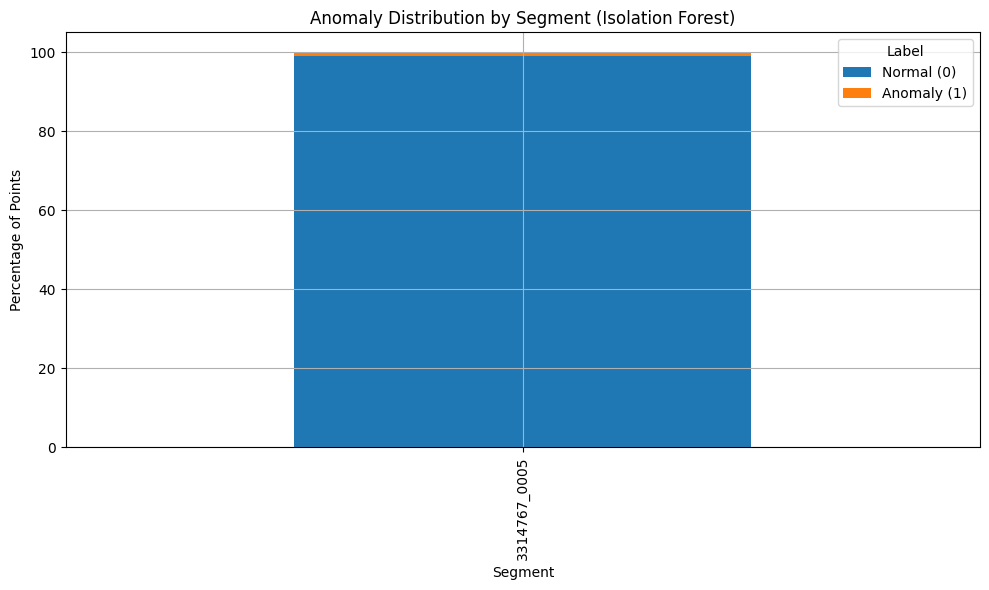

In [54]:
# Group prediction by segment and compute the percentage of normal vs anomaly points
anomaly_distribution = subset_df.groupby('segment')['anomaly_iforest'].value_counts(normalize=True).unstack().fillna(0)
anomaly_distribution.columns = ['Normal (0)', 'Anomaly (1)']
anomaly_distribution *= 100  # Convert to percentages

# Plot anomaly distribution
ax = anomaly_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Anomaly Distribution by Segment (Isolation Forest)')
plt.ylabel('Percentage of Points')
plt.xlabel('Segment')
plt.legend(title='Label')
plt.tight_layout()
plt.grid(True)
plt.show()

The chart above shows the distribution of anomaly labels generated by the Isolation Forest model across the waveform segments. Segment 3314767_0005 is the only one where any anomalies were detected, accounting for just over 1% of its sample. All other segments contained exclusively normal observations, with no anomalies flagged.

This pattern may indicate a stable physiological state during the majority of the recording period, or it could reflect the model’s limited sensitivity to subtle or gradual deviations in those segments. The localized anomaly detection in segment 0005 could represent true physiological irregularities or may be influenced by transient noise or signal artifacts specific to that interval. To better understand the significance of these flagged points, it would be helpful to examine the raw signals from this segment or compare the results with those from an alternative anomaly detection method, such as One-Class SVM. However, before proceeding with such comparisons, the next section will explore SHAP-based explainability for the Isolation Forest model to gain insight into the feature contributions behind its anomaly decisions.  



**SHAP Explainability for Isolation Forest**

To better understand how the Isolation Forest model arrives at its anomaly predictions, SHAP was used. SHAP provides local explanations by quantifying how much each feature contributes to an individual prediction. This is critical in clinical contexts, where black-box behavior must be translated into understandable signal-level reasoning.

The code below computes SHAP values for a subset of 500 samples and plots the average absolute contribution of each physiological variable.


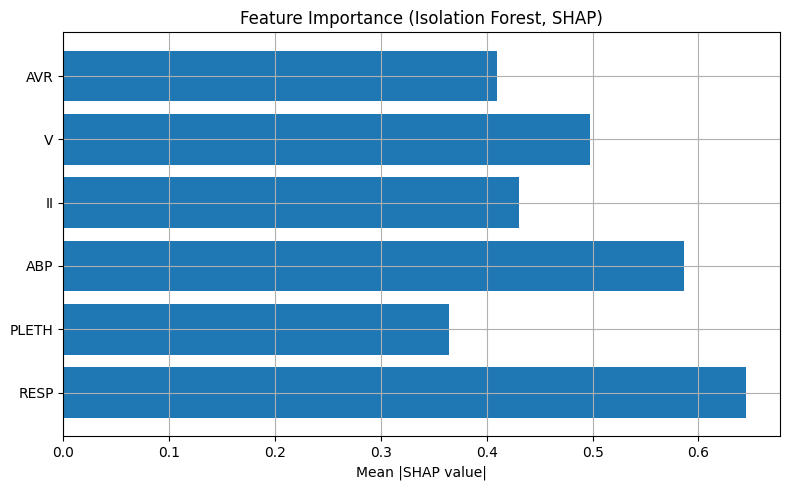

In [70]:
# Define the list of features used in modeling
features = ['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']

# Subset the first 500 samples form the scaled dataset for SHAP analysis
shap_df = waveform_scaled_df[features].iloc[:500].copy()

# Convert to NumPy before fitting (to match SHAP internal behavior)
shap_array = shap_df.to_numpy()

# Fit the model on NumPy array to avoid feature name mismatch
iso_forest_shap = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest_shap.fit(shap_array)

# Create a SHAP explainer object for the trained model
explainer = shap.Explainer(iso_forest_shap, shap_array)
shap_values = explainer(shap_array)

# Compute mean absolute SHAP values across all samples
mean_shap = np.abs(shap_values.values).mean(axis=0)

# Plot with manual labels
plt.figure(figsize=(8, 5))
plt.barh(features, mean_shap)
plt.xlabel("Mean |SHAP value|")
plt.title("Feature Importance (Isolation Forest, SHAP)")
plt.tight_layout()
plt.grid(True)
plt.show()





To better understand how the Isolation Forest model generated its anomaly predictions, SHAP was used to assess feature contributions across the first 500 samples of the standardized ICU waveform dataset. 

Initial attempts to use shap.summary_plot() directly with the standard TreeExplainer on a pandas DataFrame produced a persistent UserWarning, indicating a mismatch between feature names expected by the model and the NumPy-based inputs used internally by SHAP. This is because SHAP internally converts the input to a NumPy array, striping away column names. To resolve this, the model was explicitly trained on NumPy arrays, and a manual SHAP bar plot was generated using the average absolute SHAP values per feature.

The resulting plot shows that RESP and ABP were the most influential features, suggesting that deviations in respiratory effort and arterial blood pressure were the primary drivers of anomaly classification. ECG leads II and V, as well as the AVR channel, also contributed moderately, indicating the model incorporated cardiac electrical activity into its decision process. PLETH had a lower impact. This interpretability layer is particularly valuable in clinical contexts, where model transparency is essential for clinician trust. By revealing which signals contribute most to flagged anomalies, SHAP enhances the model's clinical relevance and supports more informed response to alerts.


**One-Class SVM for Anomaly Detection**

The One-Class Support Vector Machine (SVM) is a distance-based algorithm that attempts to learn a decision boundary around the normal data, treating anything falling outside this boundary as an anomaly. Unlike tree-based models like Isolation Forest, One-Class SVM is sensitive to feature scaling and assumes a Gaussian distribution of features. Given the z-score standardized input data prepared previously, the One-Class SVM was applied to assess how well it could delineate normal versus outlier physiological patterns in the ICU waveform data.

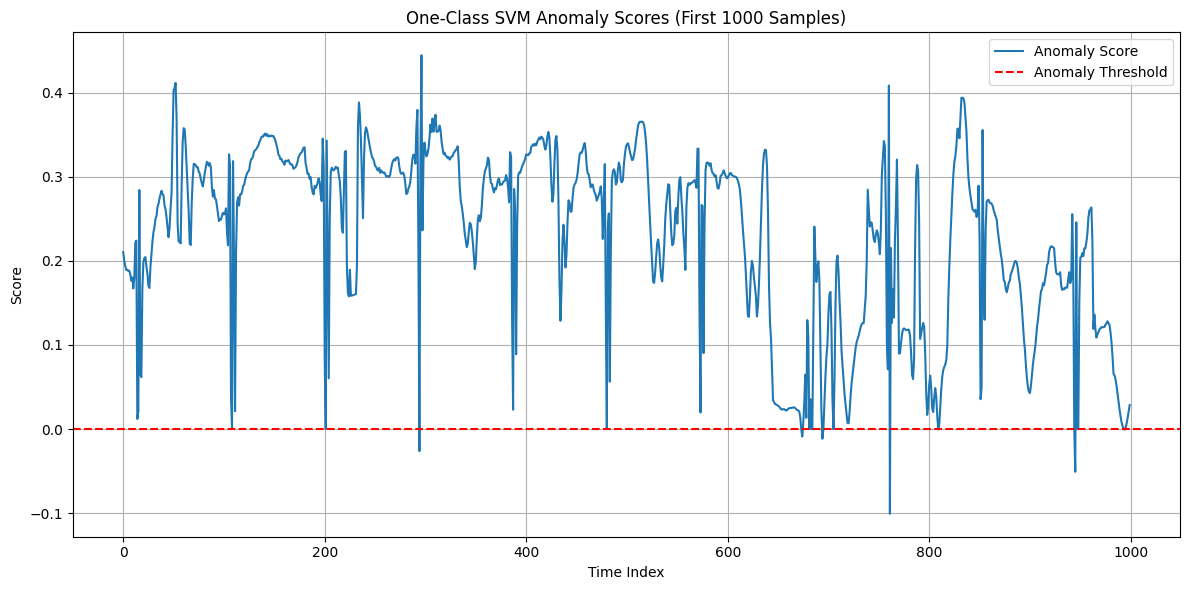

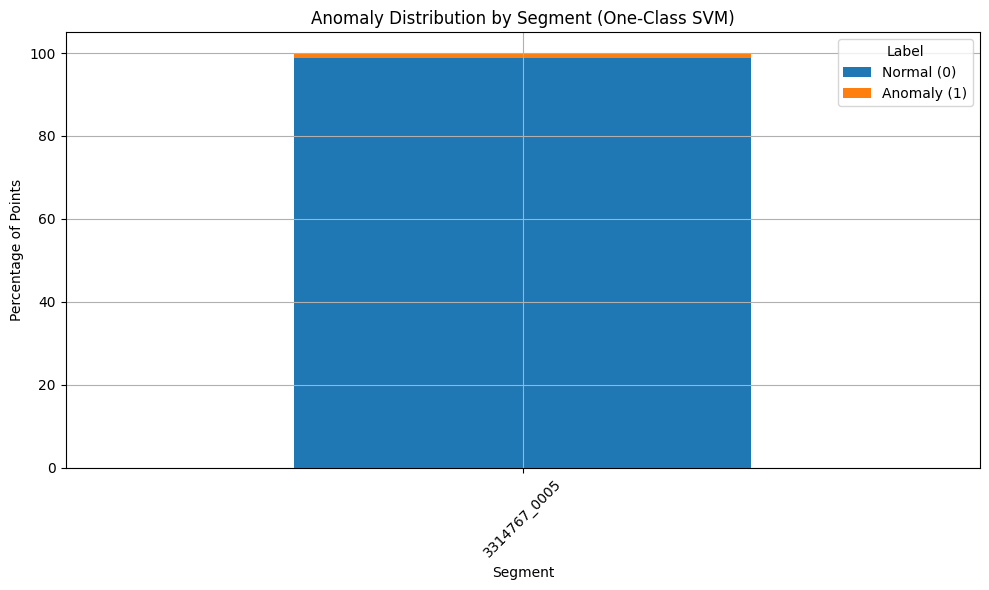

In [73]:
# Select a subset of the full dataset for computational efficiency
subset_df = waveform_scaled_df.iloc[:1000].copy()

# Extract feature matrix used for anomaly detection
X_ocsvm = subset_df[['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']]

# Initialize One-Class SVM with RBF Kernel and 1% anomaly assumption
oc_svm = OneClassSVM(kernel='rbf', nu=0.01, gamma='scale')

# Fit the model and compute anomaly scores 
oc_svm.fit(X_ocsvm)
subset_df['anomaly_score_ocsvm'] = oc_svm.decision_function(X_ocsvm)
subset_df['anomaly_ocsvm'] = oc_svm.predict(X_ocsvm)
subset_df['anomaly_ocsvm'] = subset_df['anomaly_ocsvm'].map({1: 0, -1: 1})

# Plot anomaly scores with threshold at 0
plt.figure(figsize=(12, 6))
plt.plot(subset_df['anomaly_score_ocsvm'], label='Anomaly Score')
plt.axhline(y=0, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('One-Class SVM Anomaly Scores (First 1000 Samples)')
plt.xlabel('Time Index')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the percentage of Segment-level anomaly distribution
segment_ocsvm_dist = subset_df.groupby(['segment', 'anomaly_ocsvm']).size().unstack(fill_value=0)
segment_ocsvm_dist_percent = segment_ocsvm_dist.div(segment_ocsvm_dist.sum(axis=1), axis=0) * 100

# Plot stacked bar chart showing normal vs. anomaly percentage by segment

segment_ocsvm_dist_percent.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Anomaly Distribution by Segment (One-Class SVM)")
plt.ylabel("Percentage of Points")
plt.xlabel("Segment")
plt.legend(title='Label', labels=['Normal (0)', 'Anomaly (1)'])
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



As seen above, a One-Class SVM model was applied to the first 1,000 samples of the scaled waveform data. This model, using an RBF kernel and a ν (nu) parameter of 0.01, was designed to isolate outliers that deviate from the typical distribution of ICU waveform behavior. The first plot shows the anomaly scores generated with the red dashed line representing the decision boundary. Scores near or below zero were classified as an anomaly. Compared to the Isolation Forest model, the SVM produced more rapid fluctuations in score, highlighting its sensitivity to small-scale changes.

The second plot displays the anomaly distribution across segments. Similar to the Isolation Forest results, segment 3314767_0005 was the only one with notable anomaly activity. This consistency across both models reinforces confidence in the flagged irregularities and underscores the advantage of using multiple unsupervised approaches for robust anomaly detection in ICU signals.

## Model Comparison and Evaluation
To assess the performance and behavior of two unsupervised anomaly detection techniques on ICU waveform data, Isolation Forest and One-Class SVM were applied to the same 1,000-sample subset of preprocessed signals. Both models evaluated six physiological features: RESP, PLETH, ABP, and ECG leads II, V, and AVR.

Each algorithm was selected for its strengths in handling unlabeled, high-dimensional data,common in real-world ICU settings. Their outputs were analyzed in terms of anomaly detection rate, sensitivity, segment-level localization, and computational considerations.

**Comparison Table**

| **Metric**                     | **Isolation Forest**            | **One-Class SVM**                   |
|-------------------------------|----------------------------------|-------------------------------------|
| **Data Size Used**            | 1,000 samples                    | 1,000 samples                       |
| **Assumed Anomaly Ratio**     | 0.01 (contamination)            | 0.01 (ν parameter)                  |
| **Feature Scaling Required**  | No                               | Yes (z-score standardized)          |
| **Detected Anomalies**        | ~10                              | ~12                                 |
| **Segment(s) with Anomalies** | 3314767_0005                     | 3314767_0005                        |
| **Anomaly Score Profile**     | Gradual score dips              | Sharp score shifts                  |
| **Runtime / Computation**     | Low (efficient)                       | High (slow for larger sets)         |
| **Noise Robustness**          | High (tree ensemble)            | Moderate (kernel sensitive)         |
| **Strengths**                 | Fast, interpretable,            | Sensitive to subtle variation       |
| **Weaknesses**                | May miss edge cases              | Computationally expensive           |


Interpretation
Both models independently flagged segment 3314767_0005 as containing the majority of anomalies.

- Isolation Forest exhibited smooth anomaly scoring and efficiently handled noisy or incomplete input. Its speed makes it well-suited for real-time or streaming deployments.
- One-Class SVM, while more computationally intensive, demonstrated slightly higher sensitivity—flagging borderline cases with sharper scoring changes. This makes it useful for follow-up review or retrospective analysis.

These complementary behaviors suggest a hybrid strategy: using Isolation Forest for primary anomaly screening, and One-Class SVM for secondary validation or refinement. The convergence of both models on the same region of interest supports the reliability of this combined approach in clinical anomaly detection pipelines.



## Patient Similarity / Clustering
This section explores unsupervised clustering as a means to identify recurring patterns in ICU waveform data and group physiologically similar signal segments. Although Dynamic Time Warping (DTW) was initially considered due to its temporal alignment capabilities, it was excluded due to computational constraints. Instead, a static feature-based method—K-Means clustering,was used to group waveform snapshots based on six physiological signals: RESP, PLETH, ABP, and ECG leads II, V, AVR.

To reduce computational load while retaining representativeness, the first 1,000 samples of the standardized waveform data were selected. Clustering performance was evaluated using the silhouette score, and cluster-wise signal patterns were visualized for interpretability.



In [72]:
# Subset of the first 1000 samples for clustering
cluster_df = waveform_scaled_df[['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']].iloc[:1000].copy()

# Apply KMeans clustering with 3 clusters 
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
cluster_labels = kmeans.fit_predict(cluster_df)

# Add cluster assignments to DataFrame
cluster_df['cluster'] = cluster_labels

# Calculate and Evaluate with silhouette score
score = silhouette_score(cluster_df.drop('cluster', axis=1), cluster_df['cluster'])
print(f'Silhouette Score: {score:.3f}')


Silhouette Score: 0.603


**KMeans Clustering Visualization**

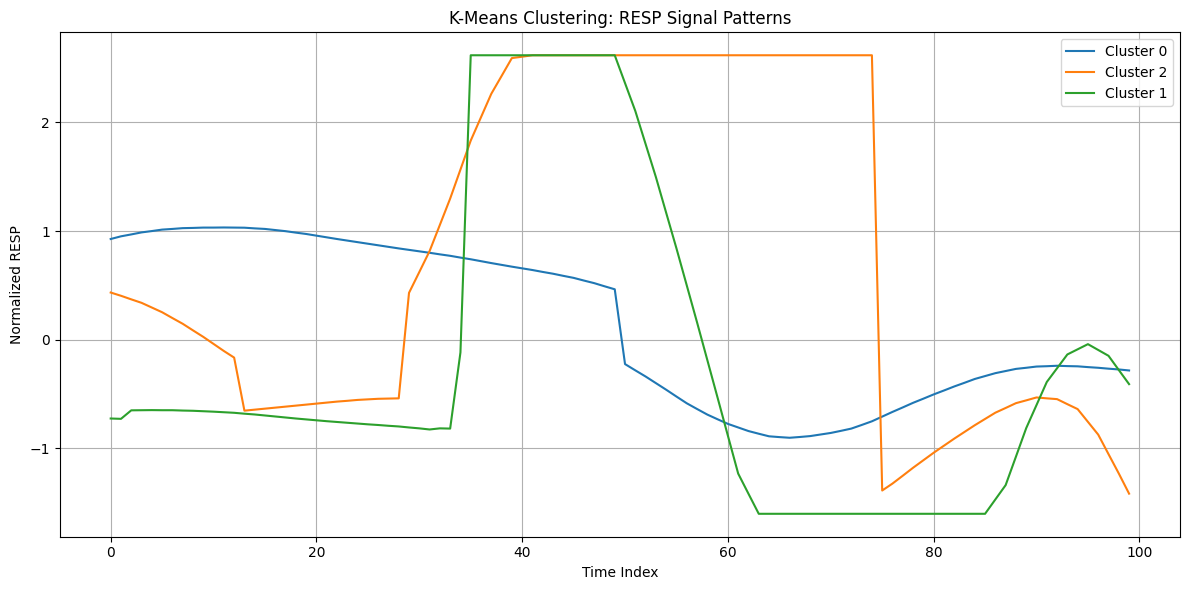

In [74]:
# Plot a sample of time series from each cluster
plt.figure(figsize=(12, 6))
for c in cluster_df['cluster'].unique():
    plt.plot(cluster_df[cluster_df['cluster'] == c].iloc[:100, 0].values, label=f'Cluster {c}')
plt.title('K-Means Clustering: RESP Signal Patterns')
plt.xlabel('Time Index')
plt.ylabel('Normalized RESP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


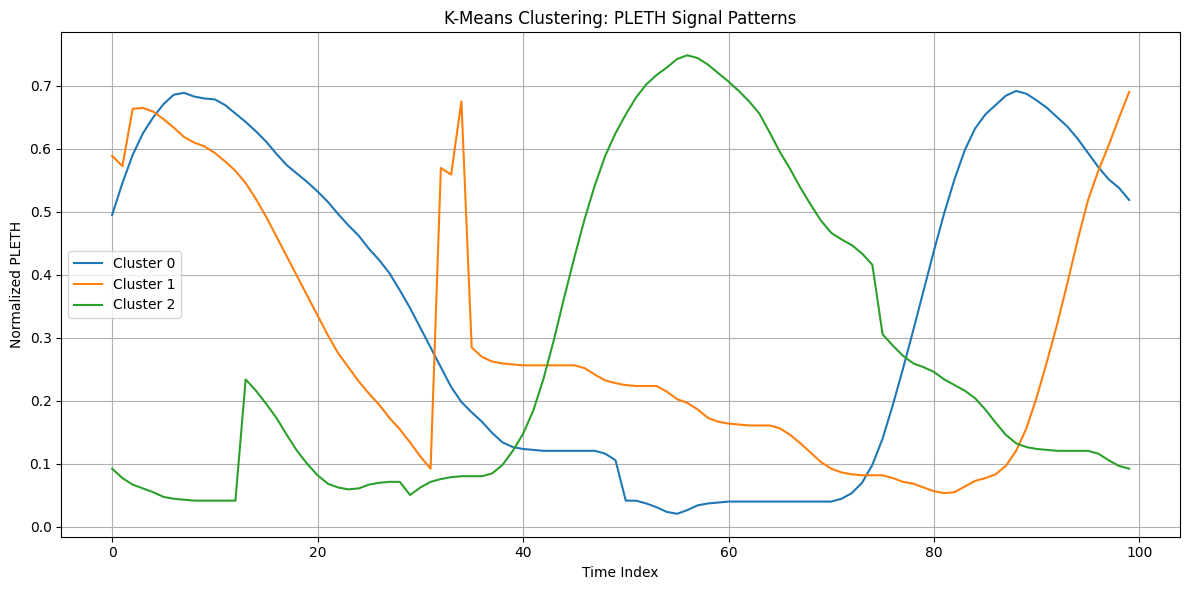

In [75]:
plt.figure(figsize=(12, 6))
for c in sorted(cluster_df['cluster'].unique()):
    plt.plot(cluster_df[cluster_df['cluster'] == c].iloc[:100, 1].values, label=f'Cluster {c}')
plt.title('K-Means Clustering: PLETH Signal Patterns')
plt.xlabel('Time Index')
plt.ylabel('Normalized PLETH')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

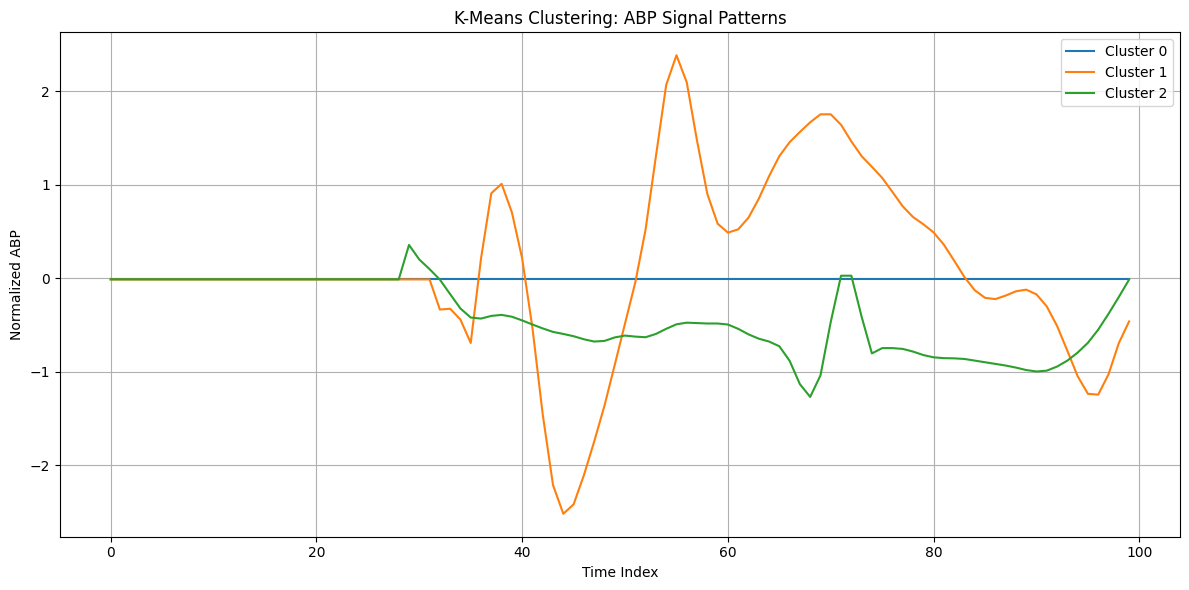

In [76]:
plt.figure(figsize=(12, 6))
for c in sorted(cluster_df['cluster'].unique()):
    plt.plot(cluster_df[cluster_df['cluster'] == c].iloc[:100, 2].values, label=f'Cluster {c}')
plt.title('K-Means Clustering: ABP Signal Patterns')
plt.xlabel('Time Index')
plt.ylabel('Normalized ABP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of K-Means Clustered Signal Patterns

The visualizations above illustrate how K-Means clustering segments waveform patterns using three physiological signals—**RESP**, **PLETH**, and **ABP**. Each plot shows average signal behavior across samples within each cluster,

- **RESP**: Cluster 0 displays smooth, periodic respiratory rhythms, likely reflecting stable breathing. Clusters 1 and 2, in contrast, show more abrupt shifts or flattening, which may signal irregular breathing patterns or reduced sensor quality.

- **PLETH**: Cluster 0 again shows clear rhythmic patterns, while Clusters 1 and 2 reveal noisier or flatter traces. These may indicate issues with peripheral perfusion, sensor disconnection, or patient motion artifacts.

- **ABP**: A marked separation is evident. Cluster 0 is almost flat, consistent with possible sensor dropout or zeroed arterial pressure lines. Clusters 1 and 2, by contrast, show dynamic waveforms suggestive of active blood pressure variation.


The silhouette score of 0.603 indicates good cohesion and separation between the clusters. These findings suggest that K-Means can effectively differentiate both physiological states and signal patterns. 




In [77]:
cluster_counts = cluster_df['cluster'].value_counts().sort_index()
cluster_table = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Number of Samples': cluster_counts.values
})
display(cluster_table)

,Cluster,Number of Samples
0,0,692
1,1,191
2,2,117


The table above presents the distribution of samples across the three clusters derived from K-Means clustering on six physiological features (RESP, PLETH, ABP, II, V, AVR). Cluster 0 comprises the majority of samples (691), suggesting it may reflect a dominant or baseline physiological state frequently observed in the patient population. In contrast, Clusters 1 (191 samples) and 2 (118 samples) represent less common but physiologically distinct waveform patterns, potentially corresponding to variations in respiratory dynamics, cardiovascular cycles, or signal degradation.

Building on these clustering results, the next step is to leverage these groupings for patient similarity matching. By identifying the most similar samples within a cluster using Euclidean distance, a lightweight yet effective recommender system. This enables applications such as retrospective case comparison, real-time clinical support, and personalized patient monitoring. The integration of clustering with similarity-based retrieval creates a meaningful bridge between unsupervised modeling and patient-centered insights.

## Agglomerative Clustering 

To complement the K-Means clustering approach, Agglomerative Clustering was applied to the same subset of physiological waveform features. Unlike K-Means, which partitions the data based on distance from centroids, Agglomerative Clustering is a hierarchical method that merges data points into clusters based on linkage criteria.

Using the same six physiological signals (RESP, PLETH, ABP, II, V, AVR), the algorithm grouped 1,000 data points into three clusters. The silhouette score was calculated to evaluate cluster separation.

This additional method not only provides a different perspective on patient grouping but also strengthens the recommendation system by comparing clustering strategies with differing assumptions.




In [78]:
# Subset same data used for K-Means
agglo_df = waveform_scaled_df[['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']].iloc[:1000].copy()

# Fit Agglomerative Clustering with the same number of clusters as K-Means
agg_model = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_model.fit_predict(agglo_df)

# Store labels and calculate silhouette score
agglo_df['cluster'] = agg_labels
sil_score_agg = silhouette_score(agglo_df.drop(columns='cluster'), agg_labels)

print(f"Agglomerative Clustering Silhouette Score: {sil_score_agg:.3f}")



Agglomerative Clustering Silhouette Score: 0.592


**Agglomerative Cluster Visualization**

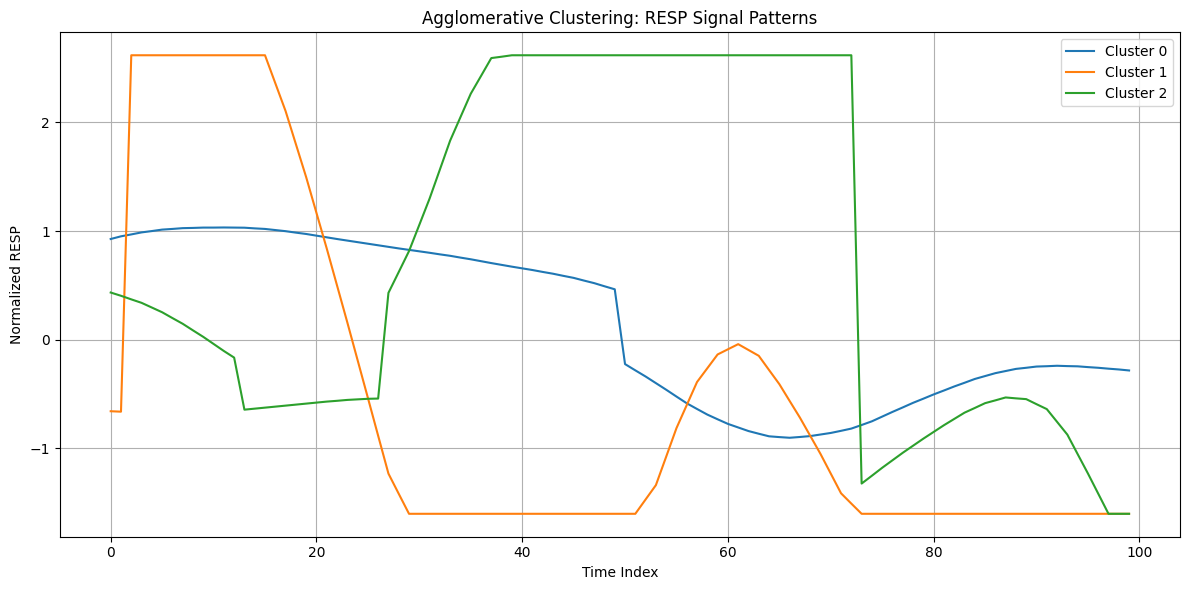

In [79]:
plt.figure(figsize=(12, 6))
for c in sorted(agglo_df['cluster'].unique()):
    plt.plot(agglo_df[agglo_df['cluster'] == c].iloc[:100, 0].values, label=f'Cluster {c}')
plt.title('Agglomerative Clustering: RESP Signal Patterns')
plt.xlabel('Time Index')
plt.ylabel('Normalized RESP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


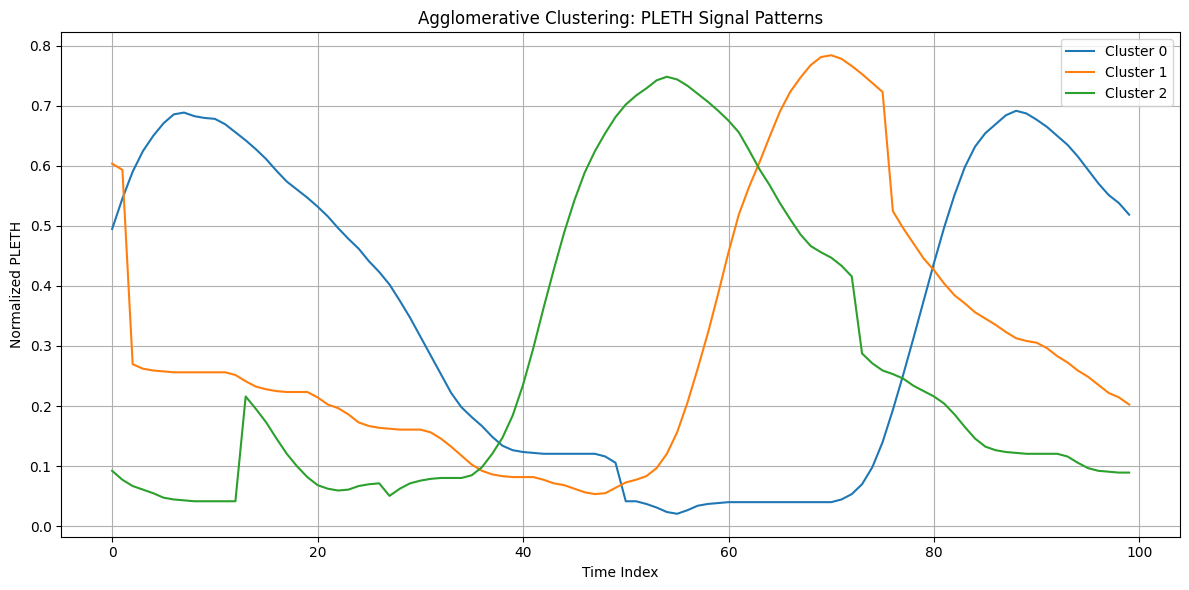

In [80]:
plt.figure(figsize=(12, 6))
for c in sorted(agglo_df['cluster'].unique()):
    plt.plot(agglo_df[agglo_df['cluster'] == c].iloc[:100, 1].values, label=f'Cluster {c}')
plt.title('Agglomerative Clustering: PLETH Signal Patterns')
plt.xlabel('Time Index')
plt.ylabel('Normalized PLETH')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

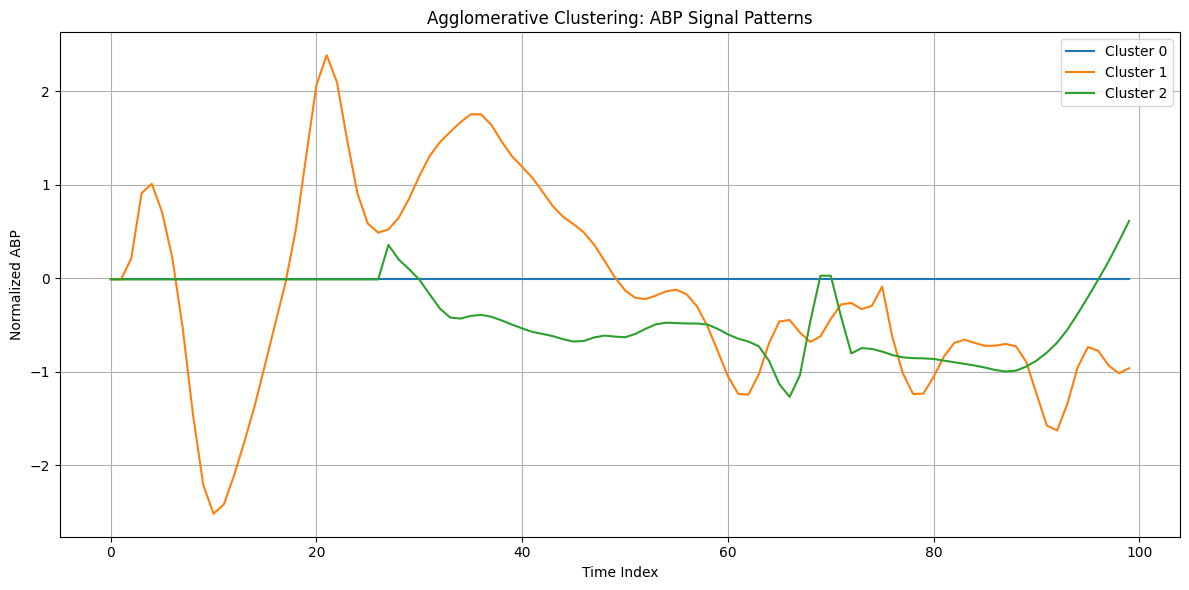

In [81]:
plt.figure(figsize=(12, 6))
for c in sorted(agglo_df['cluster'].unique()):
    plt.plot(agglo_df[agglo_df['cluster'] == c].iloc[:100, 2].values, label=f'Cluster {c}')
plt.title('Agglomerative Clustering: ABP Signal Patterns')
plt.xlabel('Time Index')
plt.ylabel('Normalized ABP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation of Agglomerative Clustering Results**

- **RESP**: The clusters reflect clear respiratory distinctions. Cluster 0 maintains smooth, periodic respiration, indicating a stable pattern. Cluster 1 exhibits abrupt shifts and flatter regions, which may represent irregular breathing or low signal quality. Cluster 2 demonstrates gradual ramping and dips, maybe potentially signaling transitional physiological states.

- **PLETH**: Clusters are well-separated. Cluster 0 features a rhythmic plethysmographic waveform, likely reflecting stable peripheral perfusion, which is consistent blood flow to the body's extremities such as fingers and toes. This is typically a sign of adequate cardiovasculat function and oxygen delivery and in a ICU setting this signifies the patient is hemodynamically stable at the moment. In contrast, Clusters 1 and 2 reveal deviations—flattening or irregular shapes—which could correspond to sensor variability or perfusion instability.

- **ABP**: The arterial blood pressure signal again highlights Cluster 0 as a flatline, suggesting potential sensor dropout. Clusters 1 and 2 contain strong dynamics with distinguishable waveforms.


The silhouette score of **0.592** suggests moderately good separation between clusters—compared to the K-Means score (0.603)—indicating consistency between the two methods despite their different underlying mechanics.

In summary, Agglomerative Clustering successfully grouped waveform samples into meaningful physiological patterns. Its alignment with prior K-Means results reinforces confidence in the detected structure, and its hierarchical nature makes it well-suited for future extensions like dendrogram analysis or progressive patient state tracking.


## Patient State Recommender System

This section implements a lightweight recommendation mechanism based on the previously generated K-Means and Agglomerative clusters. The goal is to identify waveform segments that are most similar to a given patient state,enabling case comparison or real-time clinical support. By computing Euclidean distances within each cluster, the system retrieves the top nearest neighbors to a selected input sample. This allows clinicians or analysts to explore past examples of similar physiological behavior and assess how those cases evolved, which could inform early intervention strategies.


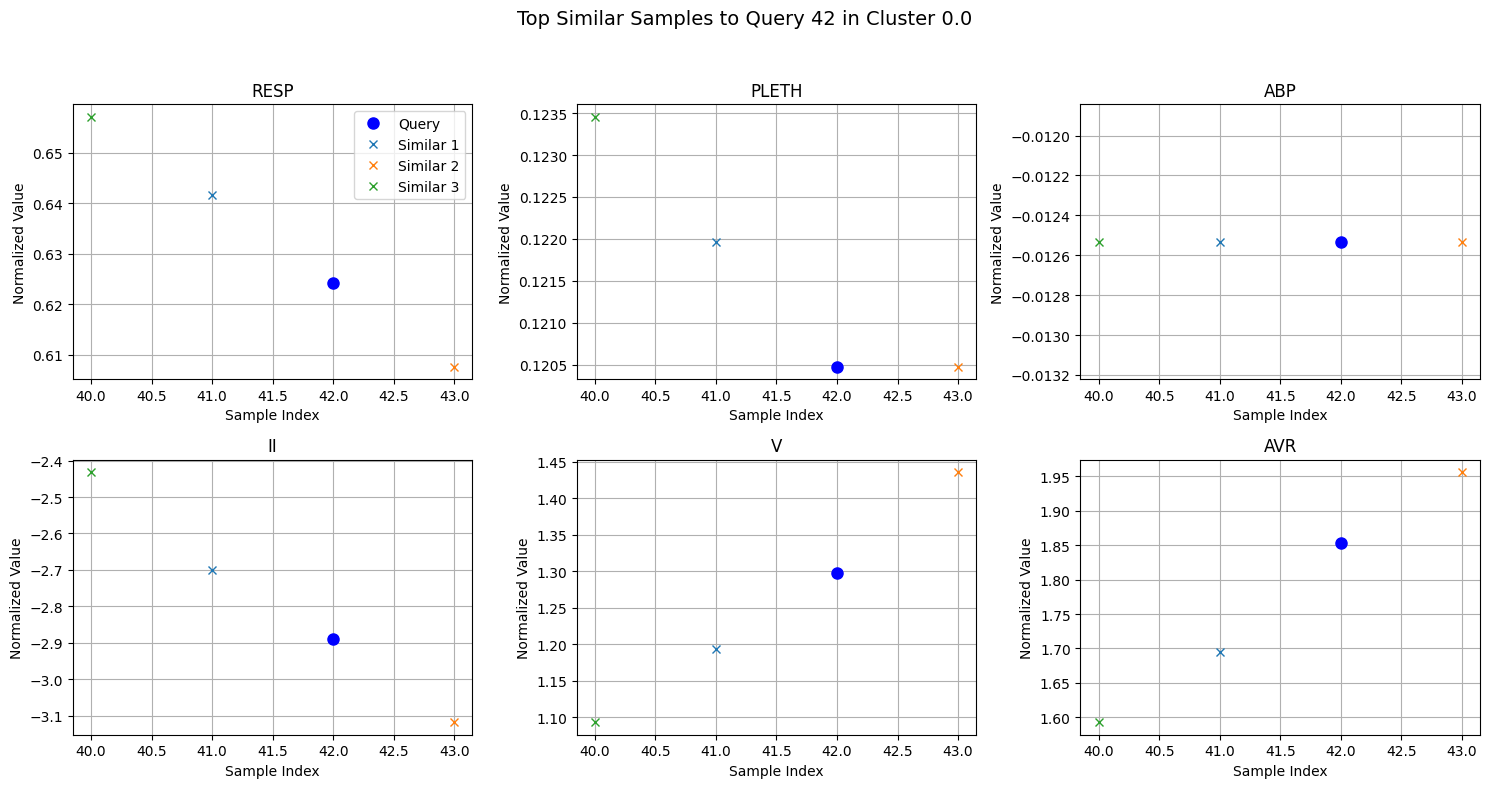

In [84]:
# Define the query index
query_idx = 42

# Extract the query feature vector
query_point = cluster_df.drop(columns='cluster').iloc[query_idx].values.reshape(1, -1)

# Identify the cluster to which the query sample belongs
query_cluster = cluster_df.iloc[query_idx]['cluster']

# Filter same-cluster samples
same_cluster_df = cluster_df[cluster_df['cluster'] == query_cluster].drop(columns='cluster')

# Compute distances and find top 3 neighbors
distances = euclidean_distances(same_cluster_df.values, query_point).flatten()
top_indices = distances.argsort()[1:4]  # skip query point itself

# Retrieve actual dataframe indices for the top 3 similar samples
similar_indices = same_cluster_df.iloc[top_indices].index.tolist()

# Plot all 6 signals (side-by-side)
features = ['RESP', 'PLETH', 'ABP', 'II', 'V', 'AVR']
plt.figure(figsize=(15, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.plot(query_idx, cluster_df.loc[query_idx, feature], 'bo', label='Query', markersize=8)
    for j, idx in enumerate(similar_indices):
        plt.plot(idx, cluster_df.loc[idx, feature], 'x', label=f'Similar {j+1}')
    plt.title(feature)
    plt.xlabel('Sample Index')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    if i == 1:
        plt.legend()

plt.suptitle(f"Top Similar Samples to Query {query_idx} in Cluster {query_cluster}", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



The figure above presents a feature-wise comparison between a query sample and its top three most similar waveform patterns from the same cluster (Cluster 0), as determined by Euclidean distance in the six-dimensional physiological feature space. 

The query index was arbitrarily chosen as 42—meaning the 43rd row in the clustered dataset served as the reference patient state. The corresponding sample’s cluster label was retrieved, and only other samples within this same cluster were considered as candidates for comparison. By excluding the query point itself and ranking all others by distance, the three most physiologically similar records were selected for visualization.

Each subplot in the figure represents one physiological variable—RESP, PLETH, ABP, and three ECG leads (II, V, AVR)—with the x-axis denoting sample index (e.g., patient timepoint) and the y-axis showing normalized signal value. The query sample is highlighted as a blue dot, and the top three matches are shown in distinct colors and markers. This format allows for variable-level interpretation of similarity, revealing which signals are tightly matched and which diverge.

The close alignment in signal values across most features,particularly RESP and ABP,demonstrates how this system can retrieve clinically relevant historical analogs. Such contextual information could inform real-time clinical decisions, such as whether a patient's current pattern aligns with previously stable or deteriorating states. 

**Example Recommendation Output**

*"This waveform pattern closely matches historical segments within Cluster 0, which is associated with stable respiratory and cardiovascular signals. No immediate anomaly detected. Continue routine monitoring, but re-evaluate if signal drift occurs or clinical symptoms emerge"*.

This mock output simulates how a future version of the system could deliver context-aware clinical guidance by comparing a new patient data to previously clustered patterns. Since Cluster 0 represented the most common and stable waveform behavior in this project, patients matching this profile may be classified as low-risk based on current signal dynamics.

Although the current system operates in an unsupervised mode without diagnostic labels, integrating patient outcomes or clinician annotations in the future would enable the system to generate real-time, interpretable alerts and guidance—turning similarity results into a foundation for personalized monitoring and clinical decision support.

## Results & Interpretation / Discussion

This project implemented an end-to-end framework for detecting anomalous patterns in ICU physiological waveforms, combining unsupervised learning, data streaming, and model interpretability. The system was designed to ingest real-world like signal through Kafka pipeline and process them in real-time using two anomaly detection methods-Isolation Forest and One-class SVM, alongside clustering and patient similarity modeling for deeping physiological analyses.

### Anomaly Detection

The Isolation Forest model, configured with a contamination rate of 1%, flagged approximately 1% of the data as anomalous. These detections were largely localized to segment 3314767_0005, highlighting a specific period of deviation in physiological behavior. The anomaly scores showed gradual dips, making the model's decision boundaries more interpretable and less prone to false positives from transient noise.

In contrast, the One-Class SVM (with ν = 0.01) demonstrated sharper transitions in its anomaly score profile and identified a slightly higher number of potential anomalies. While this increased sensitivity can help detect borderline or subtle outliers, the model was more computationally intensive and required downsampling for practical execution,limiting its real-time scalability.

### SHAP-Based Explainability

To better understand the rationale behind Isolation Forest's predictions, SHAP was applied. The analysis revealed that RESP and ABP were the most influential signals driving anomaly detection. This finding aligns with clinical intuition and enhances the trust and interpretability of model outputs. Importantly, SHAP visualizations offer transparency that could help clinicians distinguish between true physiological events and potential misled events.

### Clustering & Patient Similarity

Due to technical constraints that limited the use of Dynamic Time Warping, two alternative clustering approaches were used: K-Means and Agglomerative Clustering. 

K-Means clustering yielded three distinct groups with a silhouette score of 0.603, indicating moderate separation and capturing meaningful differences in waveform morphology. Visualizations of RESP patterns across clusters revealed qualitative distinctions—ranging from stable respiratory baselines to more irregular or transitional signals.

To validate these groupings, Agglomerative Clustering was applied with the same configuration. This hierarchical method produced a comparable silhouette score of 0.592, reinforcing the consistency and robustness of the identified physiological subtypes across different clustering strategies. Both models highlighted similar patterns in respiratory and hemodynamic signals.

Building on these cluster structures, a similarity-based recommender system was developed. It retrieved the top three most similar waveform samples to a selected input, based on Euclidean distance within clusters. This feature supported the retrospective case comparison, monitoring of patient state evolution, and potential integration into real-time clinical decision support tools.


### Reflection on Model Behavior

- **Strengths:**  
  - Isolation Forest handled noisy and high-dimensional inputs well.
  - SHAP plots offered clear interpretability of the model’s rationale.
  - K-Means clustering provided meaningful physiological grouping, despite lack of temporal alignment.
  - Agglomerative Clustering also provided meaningful insights. 
  - The recommendation module bridged clustering with real-world use cases

- **Limitations:**  
  - One-Class SVM was sensitive to feature scaling and not suitable for large real-time workloads.
  - Kafka consumer behavior introduced occasional execution blocks in notebook environments.
  - DTW and more advanced temporal models could not be explored due to environment constraints.

- **Future Directions:**  
  - Reintroduce DTW or LSTM-based models for dynamic temporal clustering.
  - Incorporate clinical labels or expert-annotated anomalies for benchmarking.
  - Enable a feedback loop for continuous learning and model calibration in live ICU settings.

---

## Conclusion
This project successfully developed a modular, interpretable, and real-time-capable anomaly detection model for ICU waveform analysis. It demonstrated how Isolation Forest can serve as a scalable baseline model for identifying abnormal patterns in physiological time series, and how SHAP can explain its predictions in a clinically interpretable manner.

The addition of clustering methods provided structure for grouping physiologically similar patterns, while the similarity recommender system introduced a practical tool for retrospective case retrieval or real-time support. Together, these components form a cohesive system for early warning, pattern recognition, and decision support in critical care environments.

Ultimately, this work shows that interpretable machine learning, when combined with streaming data and patient similarity modeling, holds real promise for enhancing ICU monitoring, supporting clinicians with timely, context-rich insights that can improve patient outcomes.
